In [1]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
import skquant.opt as skqopt #optimization routines
from scipy.linalg import expm

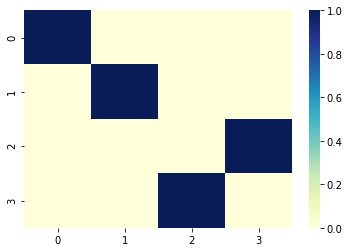

In [49]:
# matrix representation of 
U= qml.CNOT.matrix #np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

#print(U)
import seaborn
seaborn.heatmap(np.real(U),cmap="YlGnBu")
#plt.title("Ideal CCCNOT gate")
plt.show()

In [96]:
dev = qml.device("default.qubit", wires=2)


#@qml.qnode(dev)
def ansatz(params):
    l=params
    
    #H=X⊗I
    qml.RX(l[0],wires=1)
    qml.RZ(l[1],wires=1)
    qml.RX(l[2],wires=0)
    qml.RZ(l[3],wires=0)
    '''
    #H=Z⊗Z
    qml.CNOT(wires=[0,1])
    qml.RZ(l[1],wires=1)
    qml.CNOT(wires=[0,1])
    '''
    #H=X⊗X
    qml.IsingXX(l[4],wires=[0,1])
    qml.IsingZZ(l[5],wires=[0,1])
 
    #########################################################

In [97]:
trotter_steps=3

In [98]:
@qml.qnode(dev)
def circuit(params, state, apply_inv=True):
    qml.BasisState(np.array(state), wires=[0,1])
    
    for steps in range(trotter_steps):
        ansatz(params[:6])

    return qml.state()

def var_circ(params,state):
    result=(np.exp(-1j*params[0])*circuit(params[1:],state))
    
    return result

In [99]:
def get_unitary(params):
    return np.array([var_circ(params, state) for state in state_vector]).T

In [100]:
# 2nd cost the trace distance between two unitaries is taken as cost
def cost1(params):
    U_par=get_unitary(params)
    F=np.abs(np.trace(np.dot(np.transpose(np.conj(U_par)),U)))/len(U)
    
    return 1-F

In [110]:
params = np.random.random(7)
Id = np.eye(4)
state_vector=np.array([[0,0],[0,1],[1,0],[1,1]])
print(Id[3])
print(state_vector[3])

[0. 0. 0. 1.]
[1 1]


In [111]:
cost1(params)

0.8288160123616115

In [115]:
cost_arr=[]
params_arr=[]
cost_arr_opt=[]
params_arr_opt=[]

In [116]:

def optimization2(params,st):
    dev = qml.device("default.qubit.autograd", wires=2)

    opt = qml.AdagradOptimizer(stepsize=st)
    
    
    for i in range(200+1):
        params = opt.step(cost1, params)

        if i % 10 == 0:
            print(f"Cost at step {i}:", cost1(params))
            cost_arr.append(cost1(params))
            params_arr.append(params)
            print(f"fidelity of natural dynamics with actual toffoli{i}:",Fidelity(hamiltonian_matrix(params*trotter_steps/2),U))
            
    if cost1(params)>0.1:
        params=np.random.random(7)
        st=np.random.uniform(0.01,0.2)
        optimization2(params,st)
    if Fidelity(hamiltonian_matrix(params*trotter_steps/2),U)<0.99:
        params=np.random.random(7)
        st=np.random.uniform(0.01,0.2)
        optimization2(params,st)
        
    else:
        
        
        for i in range(0,10+1,1):
            print(f"Cost at step {i*10}:", cost1(params_arr[len(cost_arr)-11+i]))
            cost_arr_opt.append(cost1(params_arr[len(cost_arr)-11+i]))
            params_arr_opt.append(params_arr[len(cost_arr)-11+i])
            
    return params_arr_opt,st
        

In [117]:
#params=par[10]
optimization2(params,0.1) # st=learning rate==stepsize

Cost at step 0: 0.7217638271649901
fidelity of natural dynamics with actual toffoli0: 0.3538071789060672
Cost at step 10: 0.09215533838847412
fidelity of natural dynamics with actual toffoli10: 0.9202960762725892
Cost at step 20: 0.009910773961337549
fidelity of natural dynamics with actual toffoli20: 0.9865694250992192
Cost at step 30: 0.0012491953493660723
fidelity of natural dynamics with actual toffoli30: 0.9947144779512899
Cost at step 40: 0.0001722695190786716
fidelity of natural dynamics with actual toffoli40: 0.9958144077603303
Cost at step 50: 2.4980306987387735e-05
fidelity of natural dynamics with actual toffoli50: 0.9959714244466674
Cost at step 60: 3.7848034846188483e-06
fidelity of natural dynamics with actual toffoli60: 0.9959945375891509
Cost at step 70: 5.997185946737815e-07
fidelity of natural dynamics with actual toffoli70: 0.9959980005815379
Cost at step 80: 9.931598166090794e-08
fidelity of natural dynamics with actual toffoli80: 0.9959985148215064
Cost at step 90:

([tensor([ 7.49764863e-01,  1.04719666e+00,  9.55316849e-01,
          -6.27004328e-05,  1.57077429e+00,  7.73799041e-05,
           9.55316800e-01], requires_grad=True),
  tensor([ 7.49764863e-01,  1.04719724e+00,  9.55316698e-01,
          -2.77137657e-05,  1.57078846e+00,  3.41867410e-05,
           9.55316681e-01], requires_grad=True),
  tensor([ 7.49764863e-01,  1.04719744e+00,  9.55316646e-01,
          -1.22473191e-05,  1.57079352e+00,  1.51052444e-05,
           9.55316640e-01], requires_grad=True),
  tensor([ 7.49764863e-01,  1.04719751e+00,  9.55316628e-01,
          -5.41197621e-06,  1.57079532e+00,  6.67441937e-06,
           9.55316626e-01], requires_grad=True),
  tensor([ 7.49764863e-01,  1.04719754e+00,  9.55316621e-01,
          -2.39143681e-06,  1.57079597e+00,  2.94920722e-06,
           9.55316621e-01], requires_grad=True),
  tensor([ 7.49764863e-01,  1.04719755e+00,  9.55316619e-01,
          -1.05671381e-06,  1.57079620e+00,  1.30316506e-06,
           9.55316619e-

In [102]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])
dev = qml.device('default.qubit', wires=2)

# Hamiltonian for Toffoli
def hamiltonian_matrix(params):
    l=params
    H=l[0]*np.kron(I,I) + l[1]*np.kron(I,X) + l[2]*np.kron(I,Z) + \
        l[3]*np.kron(X,I) + l[4]*np.kron(Z,I) +\
        l[5]*np.kron(X,X) + l[6]*np.kron(Z,Z) 
    
    return expm(-1j*H)



In [103]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.abs(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [118]:
(params_arr[len(params_arr)-1])

tensor([ 7.49764863e-01,  1.04719755e+00,  9.55316618e-01,
        -1.78007068e-08,  1.57079633e+00,  2.19521262e-08,
         9.55316618e-01], requires_grad=True)

In [119]:
(params_arr[len(params_arr)-1])*trotter_steps/2

tensor([ 1.12464729e+00,  1.57079633e+00,  1.43297493e+00,
        -2.67010602e-08,  2.35619449e+00,  3.29281893e-08,
         1.43297493e+00], requires_grad=True)

In [120]:
Fidelity(hamiltonian_matrix((params_arr[len(params_arr)-1])*trotter_steps/2),U)

0.9959985897628574